# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### 2. Define the Architecture of the Policy

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [3]:
def eval_policy(env, policy, gamma, max_t, train=True):
    state = env.reset()
    saved_log_probs = []
    rewards = []
    R=0
    for t in range(max_t):
        action, log_prob = policy.act(state)
        saved_log_probs.append(log_prob)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        R+= (reward*gamma**t)
        if done:
            break 
    
    policy_loss = []
    for log_prob in saved_log_probs:
        policy_loss.append(-log_prob * R)
    
    return sum(rewards), torch.cat(policy_loss).sum()
            

In [4]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, t_num=2):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        t_grads=[]
        rewards=[]
        for i in range(t_num):
            r, pg = eval_policy(env, policy, gamma, max_t)
            t_grads.append(pg)
            rewards.append(r)
        
        scores_deque.append(sum(rewards) / t_num)
        scores.append(sum(rewards) / t_num)
        
        policy_loss = torch.stack(t_grads).sum() / t_num
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 34.96
Episode 200	Average Score: 99.17
Episode 300	Average Score: 107.69
Episode 400	Average Score: 129.50
Episode 500	Average Score: 179.42
Episode 600	Average Score: 194.69
Environment solved in 504 episodes!	Average Score: 195.01


### 4. Plot the Scores

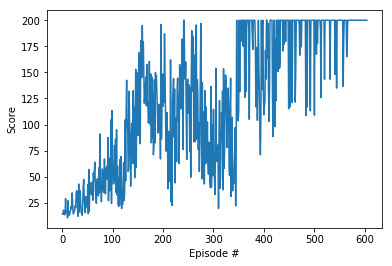

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

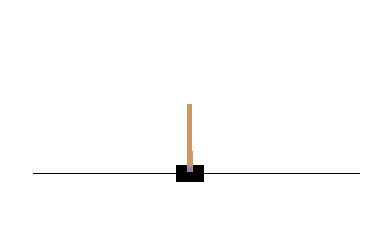

In [6]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()